In [251]:
from IPython.core.debugger import set_trace

import pandas as pd
import numpy as np
import statsmodels.api as sm

from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Make figures larger
plt.rcParams["figure.figsize"] = [16, 8]

print("pandas Version: " + pd.__version__)
print("numpy Version: " + np.__version__)
print("statsmodels Version: " + sm.__version__)

pandas Version: 1.2.4
numpy Version: 1.18.5
statsmodels Version: 0.12.2


In [282]:
TRAIN_SIZE = 0.9
TEST_SIZE = 1.0 - TRAIN_SIZE

SAMPLE_START_DATE = "2014-05-01"
SAMPLE_END_DATE = "2014-05-13 23:59:59"

ADF_P_THRESHOLD = 0.05

In [5]:
df = pd.read_csv("../data/clean/station_trips_weather.csv", parse_dates=["datetime"])
df.set_index("datetime", inplace=True)
df["station_name"] = df["station_name"].astype("category")

In [7]:
df.head(3)

,station_name,check_ins,check_outs,diff,precip_intensity,precip_probability,precip_type,temperature,humidity,wind_speed,wind_bearing,uv_index,visibility
datetime,,,,,,,,,,,,,
2017-05-15 11:00:00,Winterhuder Weg/ Zimmerstraße,2,4,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Zentralbibliothek / Münzstraße,0,2,-2,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003
2017-05-15 11:00:00,Überseering/Mexikoring,1,1,0,0.0,0.0,none,14.02,0.71,3.49,276.0,4.0,10.003


In [447]:
sample_station_a = "Am Kaiserkai/Großer Grasbrook"
sample_station_b = "Grindelberg / Bezirksamt Eimsbüttel"
sample_station_c = "Barkassenanleger/Mengestraße"

sample_df = df[
    pd.Timestamp(SAMPLE_START_DATE):pd.Timestamp(SAMPLE_END_DATE)
][["station_name", "check_ins"]]

sample_df_a = sample_df[sample_df.station_name == sample_station_a][["check_ins"]]
sample_df_b = sample_df[sample_df.station_name == sample_station_b][["check_ins"]]
sample_df_c = sample_df[sample_df.station_name == sample_station_c][[ "check_ins"]]

sample_df = sample_df[["check_ins"]].resample("H").sum()

## Building a SARIMA model

### Plot data for first examination

<AxesSubplot:xlabel='datetime'>

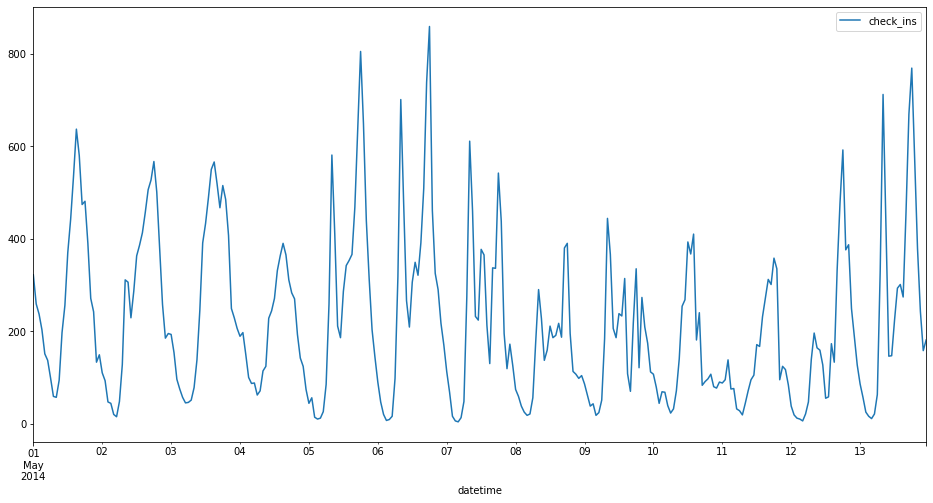

In [446]:
sample_df.plot()

<AxesSubplot:xlabel='datetime'>

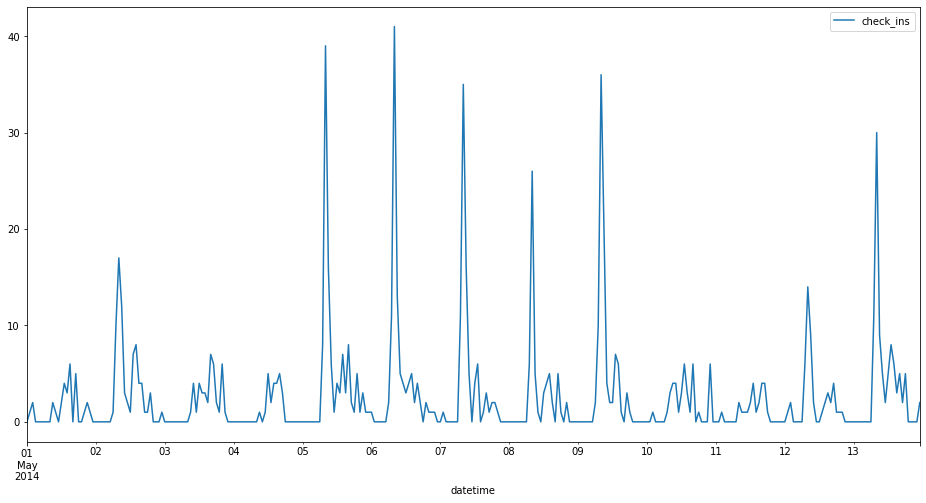

In [321]:
sample_df_a.plot()

<AxesSubplot:xlabel='datetime'>

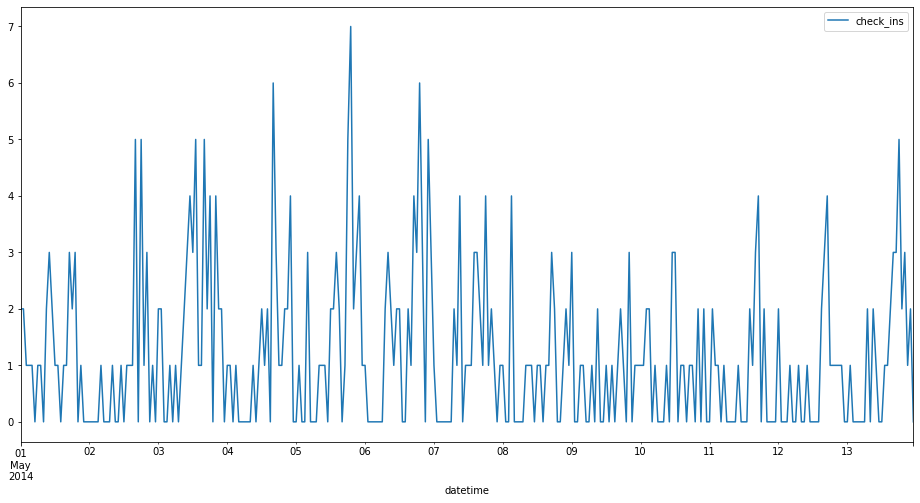

In [322]:
sample_df_b.plot()

<AxesSubplot:xlabel='datetime'>

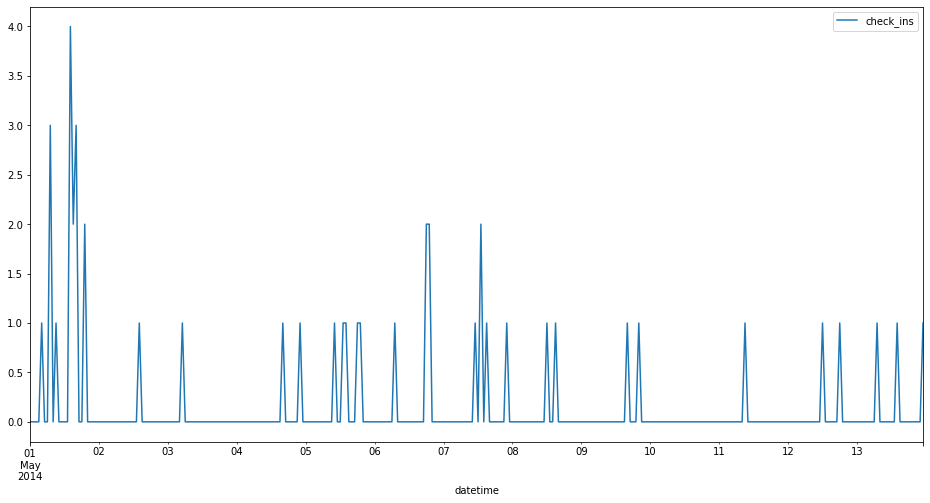

In [323]:
sample_df_c.plot()

### Check if the data is stationary with an ADF test

https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.adfuller.html

Test stationarity with the *Augmented Dickey-Fuller* test for every data set. Data is stationary if the `p` value is lower than the threshold `ADF_P_THRESHOLD` and the test statistics value is negative and lower than the critical value for 1%.

In [448]:
def check_stationarity(input_df):
    adf_result = adfuller(input_df)
    stats = adf_result[0]
    p_value = adf_result[1]
    crit1 = adf_result[4]["1%"]
    stationary = (
        p_value < ADF_P_THRESHOLD
    ) and (
        (stats < 0) and (stats < crit1)
    )
    data = {
        "stats": [stats],
        "p_value": [p_value],
        "crit1": [crit1],
        "stationary": [stationary]
    }
    return pd.DataFrame(data)

In [449]:
check_stationarity(sample_df)

,stats,p_value,crit1,stationary
0,-7.047402,5.640152e-10,-3.452263,True


In [326]:
check_stationarity(sample_df_a)

,stats,p_value,crit1,stationary
0,-10.582677,6.841305e-19,-3.451622,True


In [327]:
check_stationarity(sample_df_b)

,stats,p_value,crit1,stationary
0,-8.487025,1.344685e-13,-3.451622,True


In [328]:
check_stationarity(sample_df_c)

,stats,p_value,crit1,stationary
0,-14.429229,7.679972e-27,-3.451553,True


The check-in data is stationary for all data sets and therefore does not require differenciation when predicting with an ARIMA model. Therefore the `d` parameter can be set to 0.

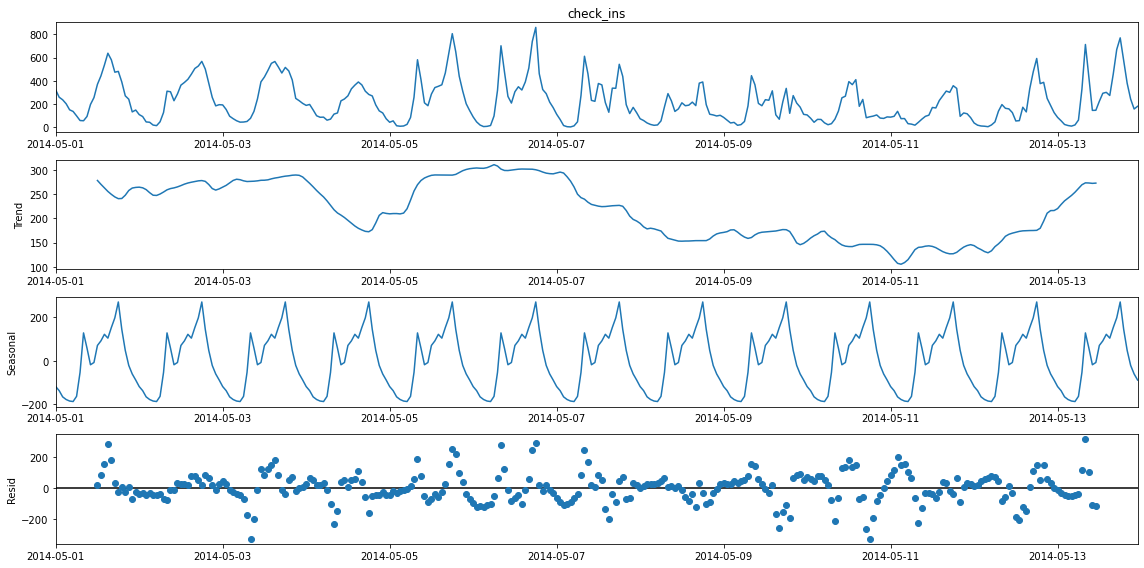

In [450]:
seasonal_decompose(sample_df.check_ins, period=24).plot()
plt.show()

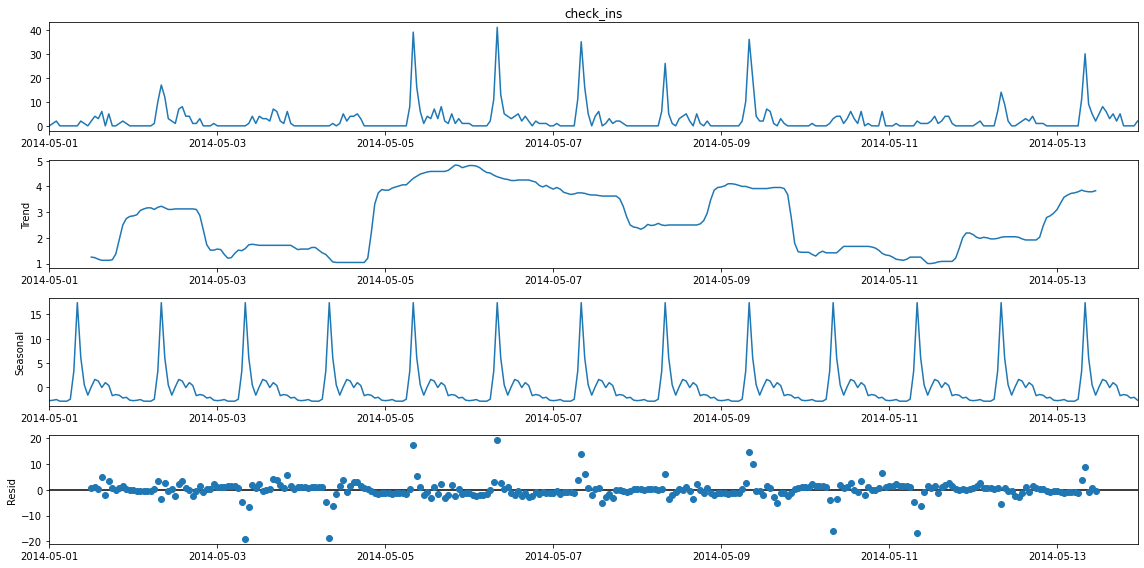

In [349]:
seasonal_decompose(sample_df_a.check_ins, period=24).plot()
plt.show()

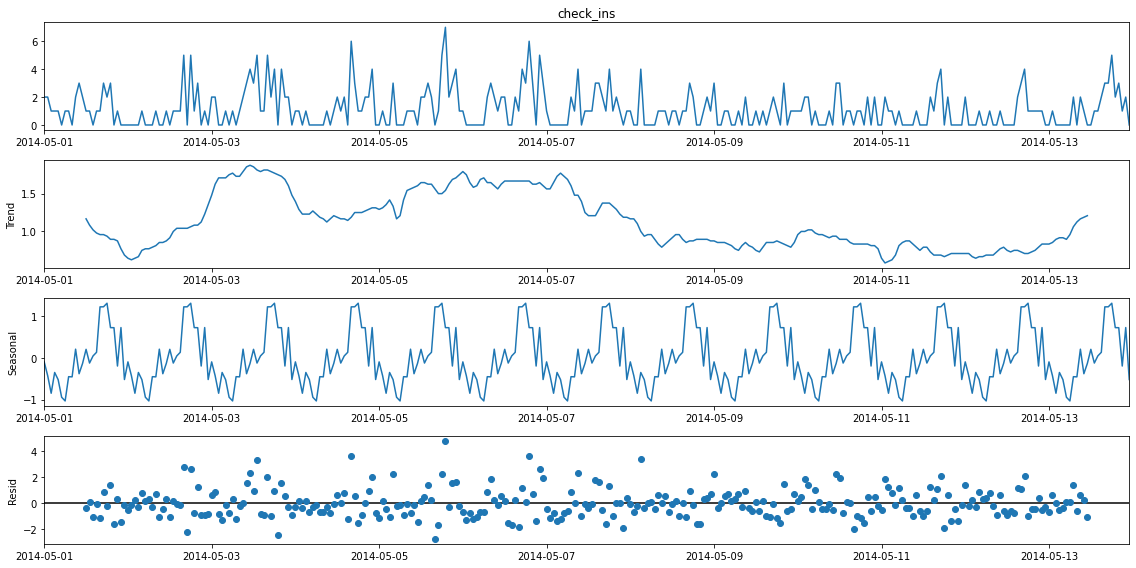

In [350]:
seasonal_decompose(sample_df_b.check_ins, period=24).plot()
plt.show()

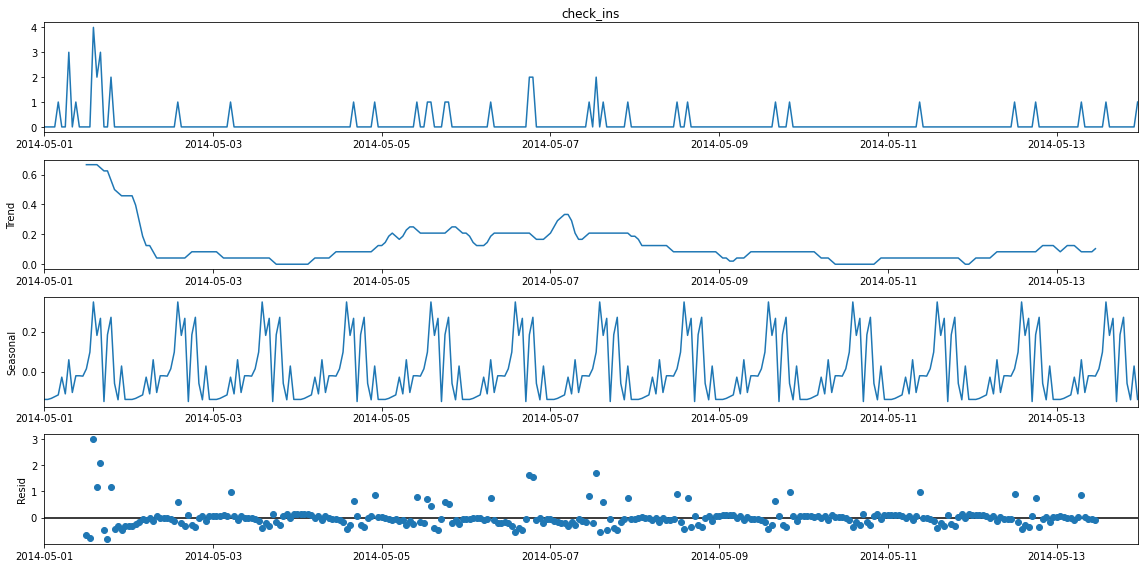

In [351]:
seasonal_decompose(sample_df_c.check_ins, period=24).plot()
plt.show()

### Check-in predictions for the next n hours overall

* Since data is seasonal, a SARIMA `(p,d,q)(P,D,Q)[S]` model will be used.
* Stationarity can be tested with the ADF method
* After applying differencing, if the ACF at lag 1 is -0.5 or more negative, the series may be overdifferenced

Rule of thumbs for parameters:

* `p` is equal to the first lag of the PACF plot that is still above the significance level, maybe one less
* `q` is equal to the first lag of the ACF plot that is still above the significance level, maybe one less
* `d` is 0 if the series has no visible trend or if the ACF at all lags is low

* `S` is equal to the ACF lag with the highest value / the amount of steps where a season is repeating
* `P` is >= 1 if the ACF is positive at lag `S`, else 0
* `D` is 1 if the seasonal pattern is stable over time, else 0
* `Q` is >= 1 if the ACF is negative at lag `S`, else 0

* `d`+`D` should be <= 2
* `P`+`Q` should be <= 2
* `p`+`d`+`q`+`P`+`D`+`Q` should be <= 6

In [497]:
train_data, test_data = train_test_split(
    sample_df, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

# Resampling to set the frequency 'H' at the index again that is lost when using 'train_test_split'
# Prevents warning later on
train_data = train_data.resample("H").sum()
test_data = test_data.resample("H").sum()

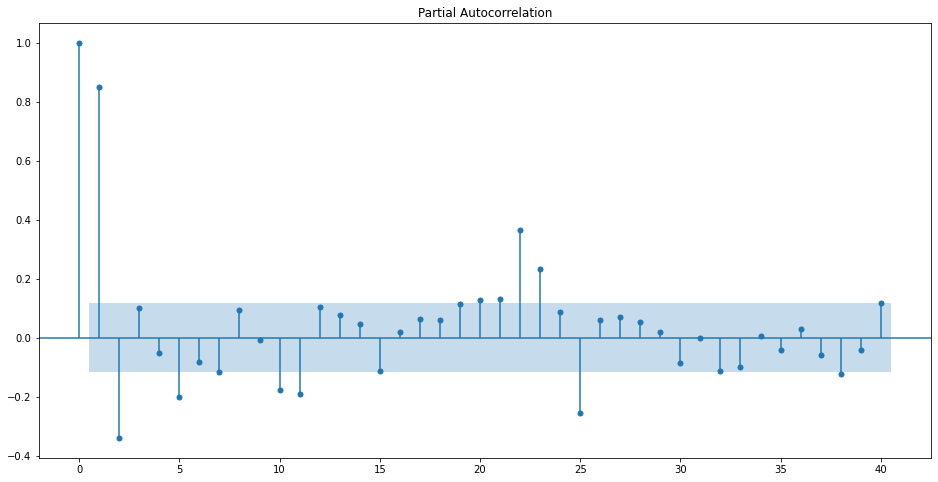

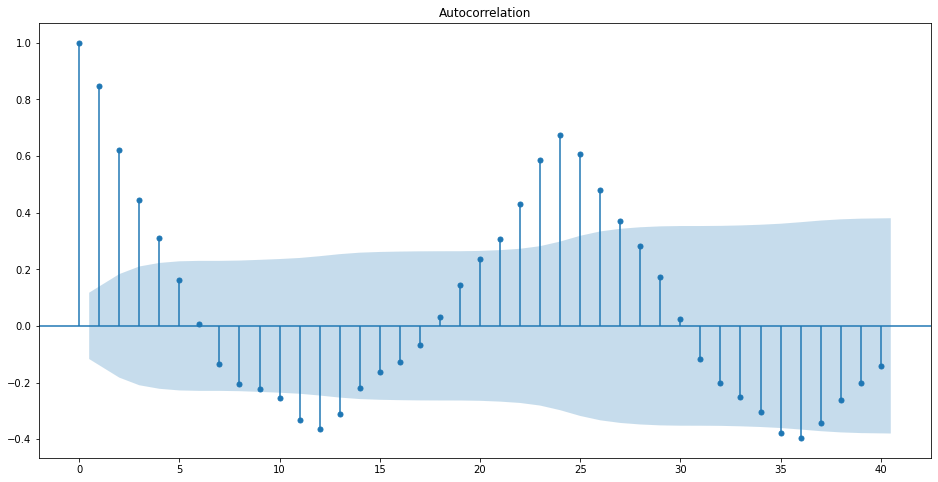

In [498]:
plot_pacf(train_data.check_ins, lags=40) # p
plt.show()

plot_acf(train_data.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1`
* `q = 3` or `q = 4`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

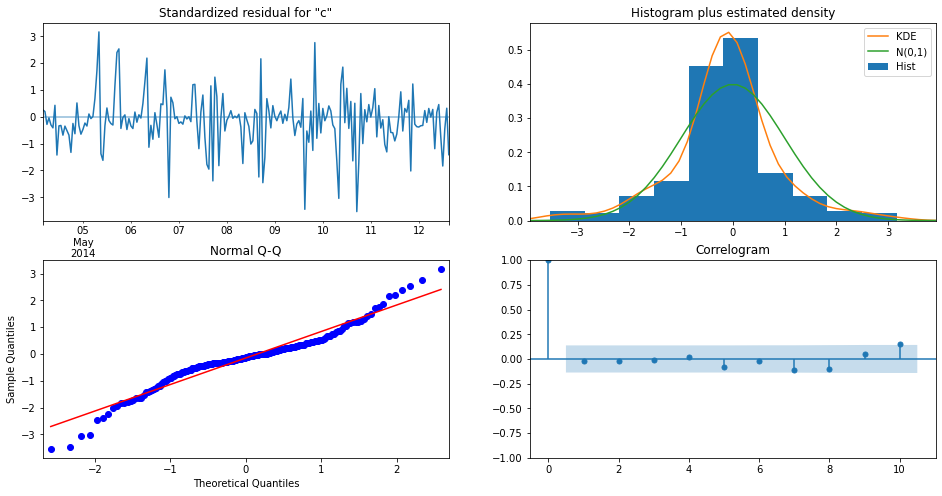

MAPE: 0.28011416972165154
RMSE: 18099.39497006865


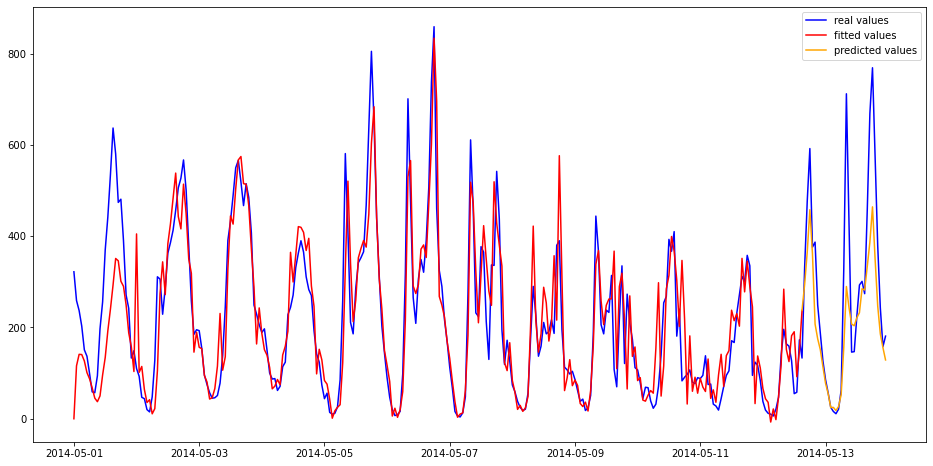

In [500]:
order = (1,0,3)
seasonal_order = (1,1,2,24)

sarima = SARIMAX(
    train_data,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_fit = sarima.fit()
sarima_fit.summary()

sarima_fit.plot_diagnostics()
plt.show()

sarima_predictions = sarima_fit.predict(
    start=train_data.index.max(), end=test_data.index.max(), dynamic=True
).to_frame()

mape = mean_absolute_percentage_error(sample_df.loc[sarima_predictions.index], sarima_predictions)
rmse = mean_squared_error(sample_df.loc[sarima_predictions.index], sarima_predictions)

print("MAPE: %s" %(mape))
print("RMSE: %s" %(rmse))

plt.plot(sample_df, color="blue", label="real values")
plt.plot(sarima_fit.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions, color="orange", label="predicted values")
plt.legend()
plt.show()

In [457]:
# MAPE
# 0.2801 (1,0,3) (1,1,2,24)
# 0.3878 (1,0,3) (1,1,1,24)
# 0.7920 (1,0,3) (1,1,3,24)

## Predicting check-ins for sample station A

In [379]:
sample_station_a

'Am Kaiserkai/Großer Grasbrook'

In [502]:
train_data_a, test_data_a = train_test_split(
    sample_df_a, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

train_data_a = train_data_a.resample("H").sum()
test_data_a = test_data_a.resample("H").sum()

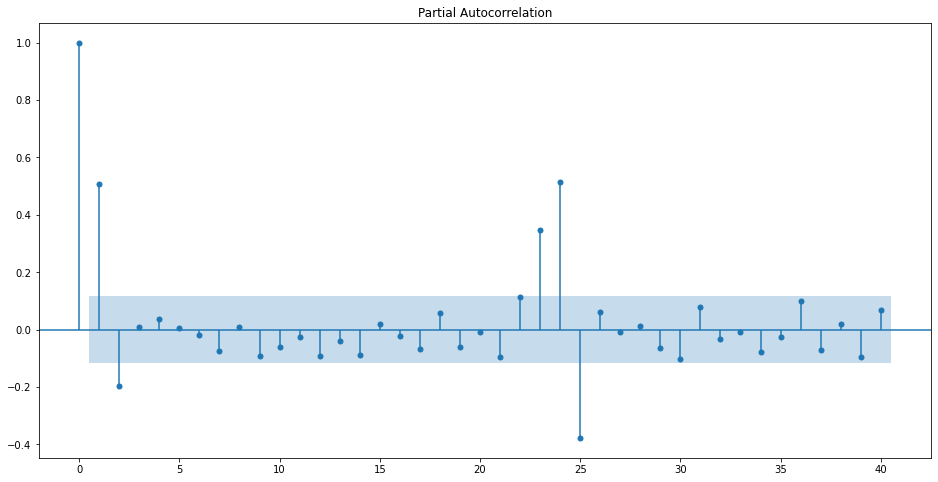

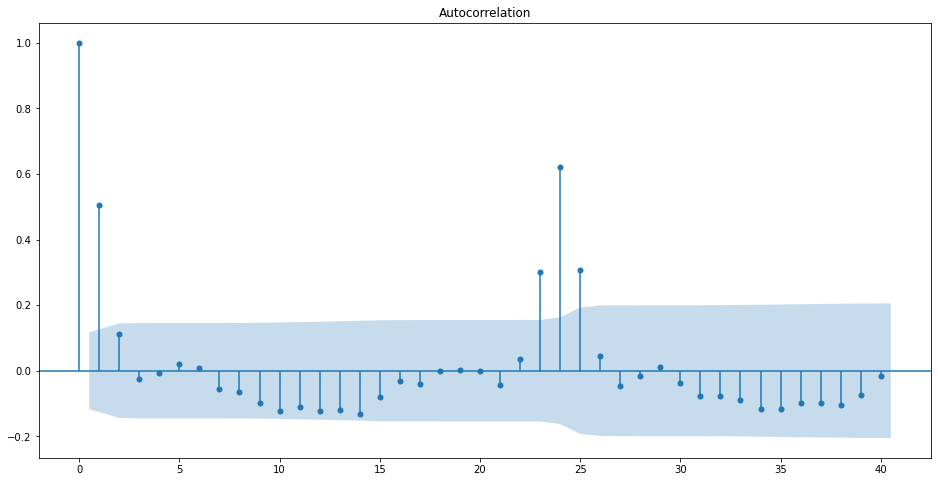

In [503]:
plot_pacf(train_data_a.check_ins, lags=40) # p
plt.show()

plot_acf(train_data_a.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1`
* `q = 1`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

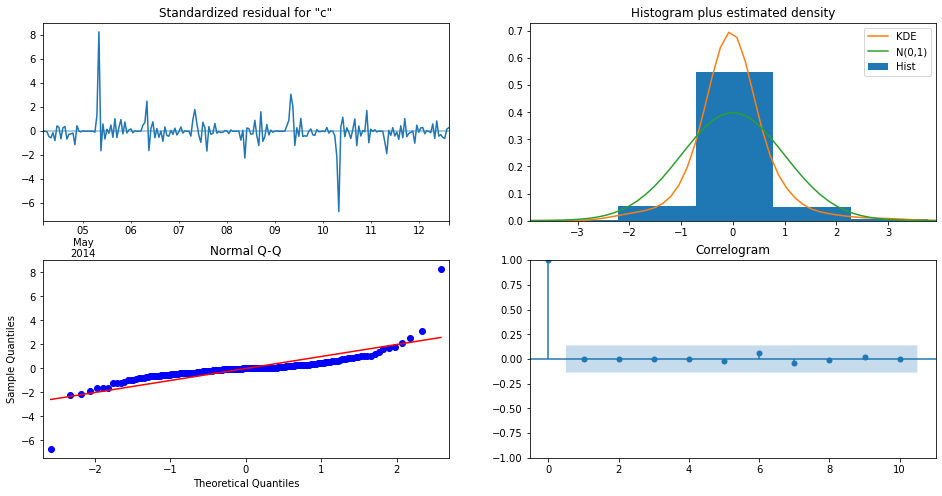

MAPE: 839795837083760.2
RMSE: 122523.13551668492


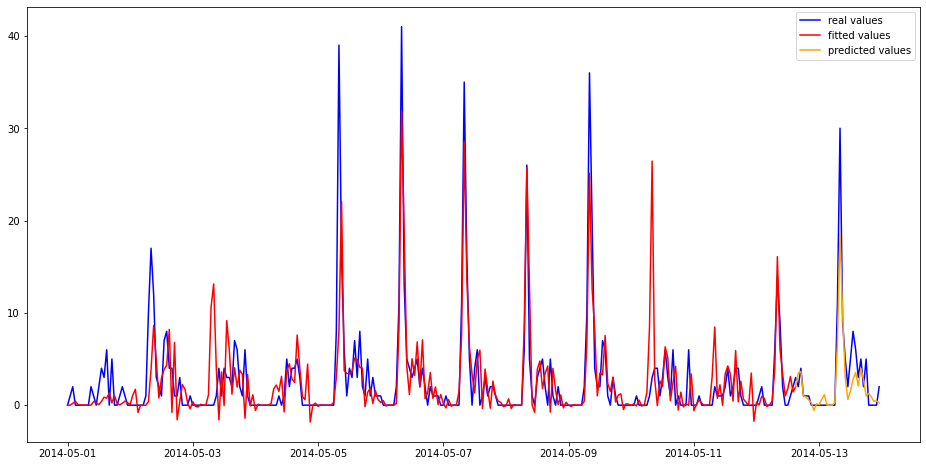

In [505]:
order_a = (1,0,3)
seasonal_order_a = (1,1,2,24)

sarima_a = SARIMAX(
    train_data_a,
    order=order_a,
    seasonal_order=seasonal_order_a,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_fit_a = sarima_a.fit()
sarima_fit_a.summary()

sarima_fit_a.plot_diagnostics()
plt.show()

sarima_predictions_a = sarima_fit_a.predict(
    start=train_data_a.index.max(), end=test_data_a.index.max(), dynamic=True
).to_frame()

mape_a = mean_absolute_percentage_error(sample_df_a.loc[sarima_predictions_a.index], sarima_predictions_a)
rmse_a = mean_squared_error(sample_df.loc[sarima_predictions_a.index], sarima_predictions_a)

print("MAPE: %s" %(mape_a))
print("RMSE: %s" %(rmse_a))

plt.plot(sample_df_a, color="blue", label="real values")
plt.plot(sarima_fit_a.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions_a, color="orange", label="predicted values")
plt.legend()
plt.show()

## Predicting check-ins for sample station B

In [387]:
sample_station_b

'Grindelberg / Bezirksamt Eimsbüttel'

In [388]:
train_data_b, test_data_b = train_test_split(
    sample_df_b, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

train_data_b = train_data_b.resample("H").sum()
test_data_b = test_data_b.resample("H").sum()

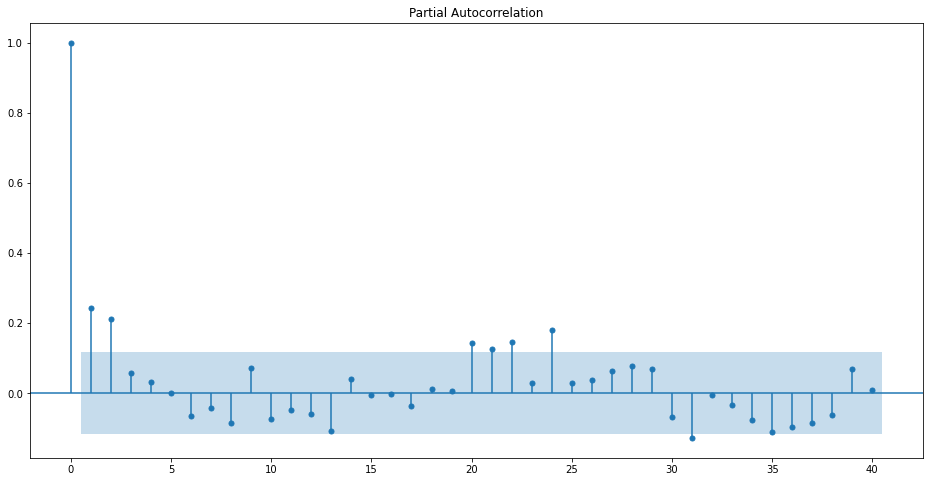

In [389]:
plot_pacf(train_data_b.check_ins, lags=40) # p
plt.show()

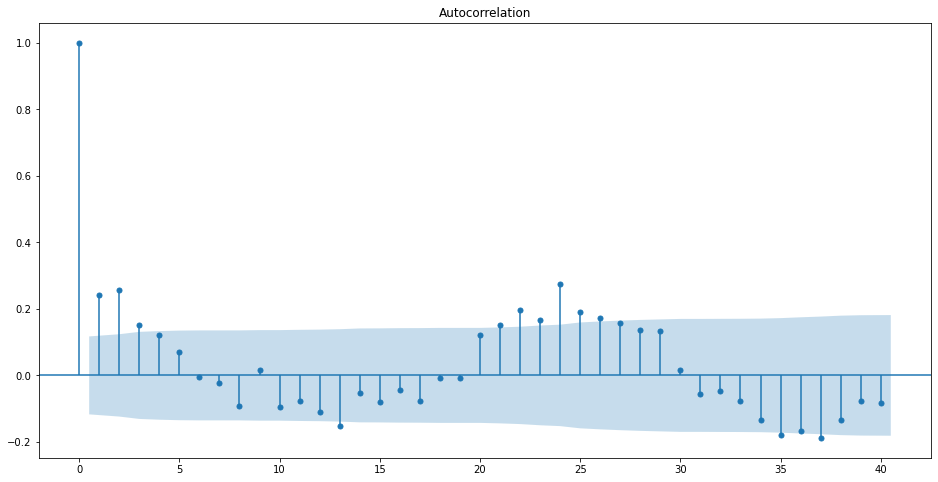

In [390]:
plot_acf(train_data_b.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 1` or `p = 2`
* `q = 1` or `q = 2`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

MAPE: 1029028333684078.4
RMSE: 0.8678458744855739


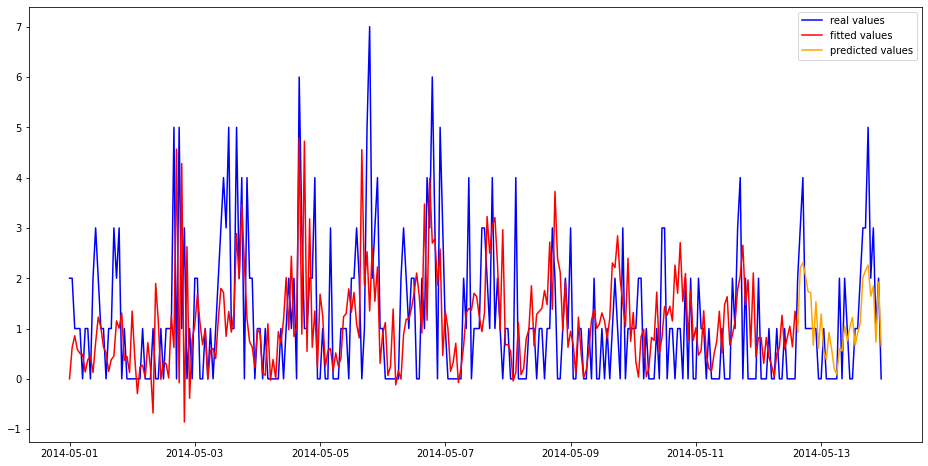

In [394]:
order_b = (1,0,3)
seasonal_order_b = (1,1,2,24)

sarima_b = SARIMAX(
    train_data_b,
    order=order_b,
    seasonal_order=seasonal_order_b,
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq="H"
)
sarima_fit_b = sarima_b.fit()
sarima_fit_b.summary()

sarima_fit_b.plot_diagnostics()
plt.show()

sarima_predictions_b = sarima_fit_b.predict(
    start=train_data_b.index.max(), end=test_data_b.index.max(), dynamic=True
).to_frame()

mape_b = mean_absolute_percentage_error(sample_df_b.loc[sarima_predictions_b.index], sarima_predictions_b)
rmse_b = mean_squared_error(sample_df_b.loc[sarima_predictions_b.index], sarima_predictions_b)

print("MAPE: %s" %(mape_b))
print("RMSE: %s" %(rmse_b))

plt.plot(sample_df_b, color="blue", label="real values")
plt.plot(sarima_fit_b.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions_b, color="orange", label="predicted values")
plt.legend()
plt.show()

## Predicting check-ins for sample station C

In [460]:
sample_station_c

'Barkassenanleger/Mengestraße'

In [461]:
train_data_c, test_data_c = train_test_split(
    sample_df_c, shuffle=False, train_size=TRAIN_SIZE, test_size=TEST_SIZE
)

train_data_c = train_data_c.resample("H").sum()
test_data_c = test_data_c.resample("H").sum()

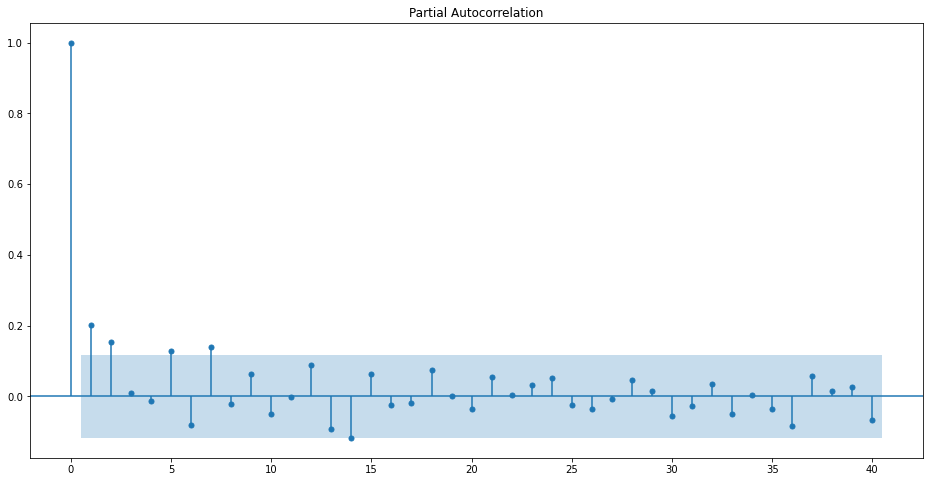

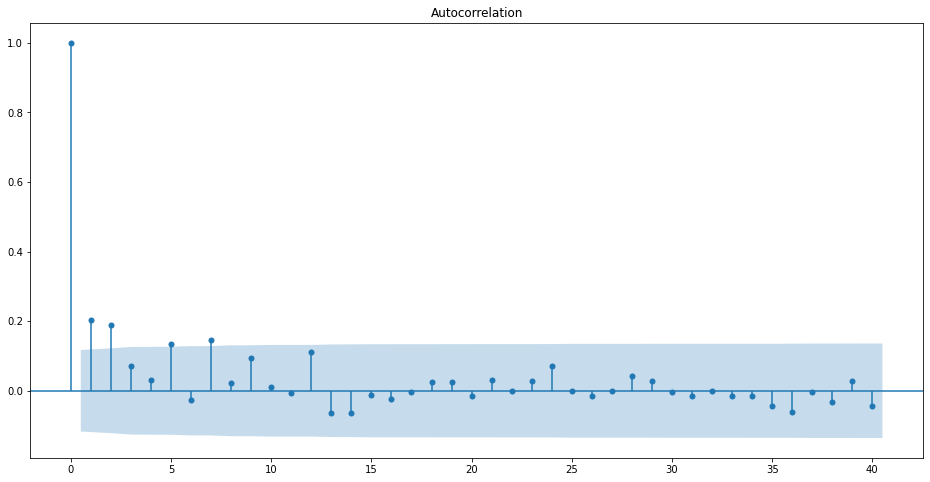

In [462]:
plot_pacf(train_data_c.check_ins, lags=40) # p
plt.show()

plot_acf(train_data_c.check_ins, lags=40) # q, S, P, Q
plt.show()

Following the rule of thumb, optimal parameters could be:

* `p = 2`
* `q = 0` or `q = 1` or `q = 2`
* `S` is 24
* `P` is 1
* `Q` is 0

As data is stationary, `d` = 0.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency H will be used.

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



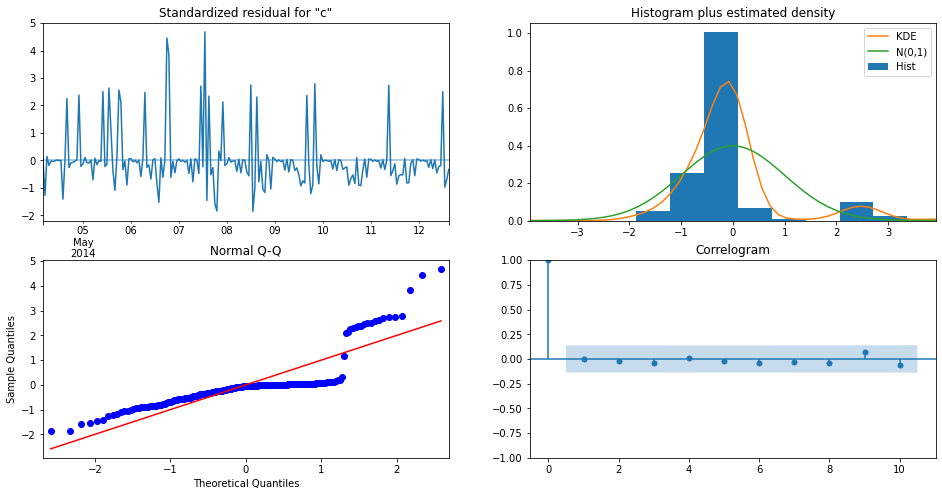

MAPE: 420143210008221.6
RMSE: 0.10934901922291003


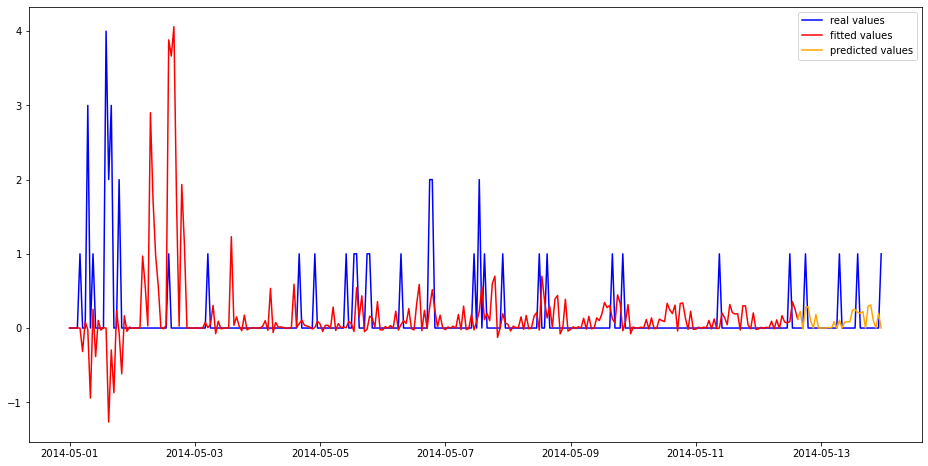

In [463]:
order_c = (1,0,3)
seasonal_order_c = (1,1,2,24)

sarima_c = SARIMAX(
    train_data_c,
    order=order_c,
    seasonal_order=seasonal_order_c,
    enforce_stationarity=False,
    enforce_invertibility=False,
    freq="H"
)
sarima_fit_c = sarima_c.fit()
sarima_fit_c.summary()

sarima_fit_c.plot_diagnostics()
plt.show()

sarima_predictions_c = sarima_fit_c.predict(
    start=train_data_c.index.max(), end=test_data_c.index.max(), dynamic=True
).to_frame()

mape_c = mean_absolute_percentage_error(sample_df_c.loc[sarima_predictions_c.index], sarima_predictions_c)
rmse_c = mean_squared_error(sample_df_c.loc[sarima_predictions_c.index], sarima_predictions_c)

print("MAPE: %s" %(mape_c))
print("RMSE: %s" %(rmse_c))

plt.plot(sample_df_c, color="blue", label="real values")
plt.plot(sarima_fit_c.fittedvalues, color="red", label="fitted values")
plt.plot(sarima_predictions_c, color="orange", label="predicted values")
plt.legend()
plt.show()

In [464]:
sarima_predictions.index

DatetimeIndex(['2014-05-12 15:00:00', '2014-05-12 16:00:00',
               '2014-05-12 17:00:00', '2014-05-12 18:00:00',
               '2014-05-12 19:00:00', '2014-05-12 20:00:00',
               '2014-05-12 21:00:00', '2014-05-12 22:00:00',
               '2014-05-12 23:00:00', '2014-05-13 00:00:00',
               '2014-05-13 01:00:00', '2014-05-13 02:00:00',
               '2014-05-13 03:00:00', '2014-05-13 04:00:00',
               '2014-05-13 05:00:00', '2014-05-13 06:00:00',
               '2014-05-13 07:00:00', '2014-05-13 08:00:00',
               '2014-05-13 09:00:00', '2014-05-13 10:00:00',
               '2014-05-13 11:00:00', '2014-05-13 12:00:00',
               '2014-05-13 13:00:00', '2014-05-13 14:00:00',
               '2014-05-13 15:00:00', '2014-05-13 16:00:00',
               '2014-05-13 17:00:00', '2014-05-13 18:00:00',
               '2014-05-13 19:00:00', '2014-05-13 20:00:00',
               '2014-05-13 21:00:00', '2014-05-13 22:00:00',
               '2014-05-

In [467]:
sarima_predictions_a.index

DatetimeIndex(['2014-05-12 15:00:00', '2014-05-12 16:00:00',
               '2014-05-12 17:00:00', '2014-05-12 18:00:00',
               '2014-05-12 19:00:00', '2014-05-12 20:00:00',
               '2014-05-12 21:00:00', '2014-05-12 22:00:00',
               '2014-05-12 23:00:00', '2014-05-13 00:00:00',
               '2014-05-13 01:00:00', '2014-05-13 02:00:00',
               '2014-05-13 03:00:00', '2014-05-13 04:00:00',
               '2014-05-13 05:00:00', '2014-05-13 06:00:00',
               '2014-05-13 07:00:00', '2014-05-13 08:00:00',
               '2014-05-13 09:00:00', '2014-05-13 10:00:00',
               '2014-05-13 11:00:00', '2014-05-13 12:00:00',
               '2014-05-13 13:00:00', '2014-05-13 14:00:00',
               '2014-05-13 15:00:00', '2014-05-13 16:00:00',
               '2014-05-13 17:00:00', '2014-05-13 18:00:00',
               '2014-05-13 19:00:00', '2014-05-13 20:00:00',
               '2014-05-13 21:00:00', '2014-05-13 22:00:00',
               '2014-05-

In [481]:
sample_df.loc[sarima_predictions.index].check_ins.values

array([133, 332, 477, 592, 376, 387, 249, 188, 127,  86,  57,  25,  16,
        11,  21,  63, 329, 712, 433, 146, 147, 224, 293, 301, 274, 458,
       669, 769, 571, 379, 243, 158, 181])

In [468]:
sample_df_a.loc[sarima_predictions_a.index]

,check_ins
2014-05-12 15:00:00,3
2014-05-12 16:00:00,2
2014-05-12 17:00:00,4
2014-05-12 18:00:00,1
2014-05-12 19:00:00,1
2014-05-12 20:00:00,1
2014-05-12 21:00:00,0
2014-05-12 22:00:00,0
2014-05-12 23:00:00,0
2014-05-13 00:00:00,0


In [476]:
sarima_predictions.predicted_mean

2014-05-12 15:00:00     37.347223
2014-05-12 16:00:00    148.463804
2014-05-12 17:00:00     54.022813
2014-05-12 18:00:00    104.574814
2014-05-12 19:00:00    120.275276
2014-05-12 20:00:00    139.756015
2014-05-12 21:00:00    129.085327
2014-05-12 22:00:00     92.869666
2014-05-12 23:00:00     80.162432
2014-05-13 00:00:00     71.152295
2014-05-13 01:00:00     69.603610
2014-05-13 02:00:00    106.160936
2014-05-13 03:00:00     58.908249
2014-05-13 04:00:00     68.573308
2014-05-13 05:00:00     29.498812
2014-05-13 06:00:00     30.302909
2014-05-13 07:00:00     30.529195
2014-05-13 08:00:00     46.703003
2014-05-13 09:00:00     67.775003
2014-05-13 10:00:00    127.846155
2014-05-13 11:00:00    116.238468
2014-05-13 12:00:00    168.963894
2014-05-13 13:00:00    171.682075
2014-05-13 14:00:00    233.548209
2014-05-13 15:00:00    240.740626
2014-05-13 16:00:00    375.302503
2014-05-13 17:00:00    248.808939
2014-05-13 18:00:00    308.658872
2014-05-13 19:00:00    345.821928
2014-05-13 20:

In [469]:
sarima_predictions_a

,predicted_mean
2014-05-12 15:00:00,2.004742
2014-05-12 16:00:00,3.491782
2014-05-12 17:00:00,3.653796
2014-05-12 18:00:00,0.996042
2014-05-12 19:00:00,0.877093
2014-05-12 20:00:00,0.576974
2014-05-12 21:00:00,0.274148
2014-05-12 22:00:00,-0.572275
2014-05-12 23:00:00,0.149146
2014-05-13 00:00:00,0.061700
